# 🚗 Car Evaluation Classification
**Author:** Muzhaffar Ammar  
**Role:** Data Analyst / Data Scientist — Portfolio  
**Tools:** Python (Pandas, NumPy), Scikit-Learn, XGBoost, Matplotlib, Seaborn

**Overview:**  
This project builds and compares Decision Tree and XGBoost classifiers to predict car acceptability (target: `class`) using the UCI Car Evaluation dataset.  
Perform EDA, preprocessing, model training, evaluation, and provide business-oriented insights.


#### 1) Import Data

Car Evaluation Dataset


In [2]:
!wget https://archive.ics.uci.edu/static/public/19/car+evaluation.zip

--2025-11-09 10:19:44--  https://archive.ics.uci.edu/static/public/19/car+evaluation.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘car+evaluation.zip’

car+evaluation.zip      [ <=>                ]   6.19K  --.-KB/s    in 0s      

2025-11-09 10:19:44 (96.3 MB/s) - ‘car+evaluation.zip’ saved [6342]



Import Library


In [2]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Preprocessing & modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Models
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier

# Utilities
import joblib  # to save model
import warnings
warnings.filterwarnings("ignore")

print("Libraries loaded.")


Libraries loaded.


## 📥 Load dataset
Sumber: UCI Machine Learning Repository — *Car Evaluation Dataset*.  
Penjelasan singkat kolom: `buying, maint, doors, persons, lug_boot, safety, class`.


In [3]:
# Read dataset
df = pd.read_csv("car.csv")

# Quick peek
df.head()


,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [4]:
# Structure and Check Missing Value
print("Shape:", df.shape)
print("\nDatatypes:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())

# Unique values per column (categorical dataset)
for c in df.columns:
    print(f"{c}: {df[c].unique()}")


Shape: (1728, 7)

Datatypes:
 buying      object
maint       object
doors       object
persons     object
lug_boot    object
safety      object
class       object
dtype: object

Missing values:
 buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64
buying: ['vhigh' 'high' 'med' 'low']
maint: ['vhigh' 'high' 'med' 'low']
doors: ['2' '3' '4' '5more']
persons: ['2' '4' 'more']
lug_boot: ['small' 'med' 'big']
safety: ['low' 'med' 'high']
class: ['unacc' 'acc' 'vgood' 'good']


## 🔍 Exploratory Data Analysis (EDA)
Objective: To understand the distribution of each feature, class balance, and initial insights. Visualization helps when writing insights at the end.



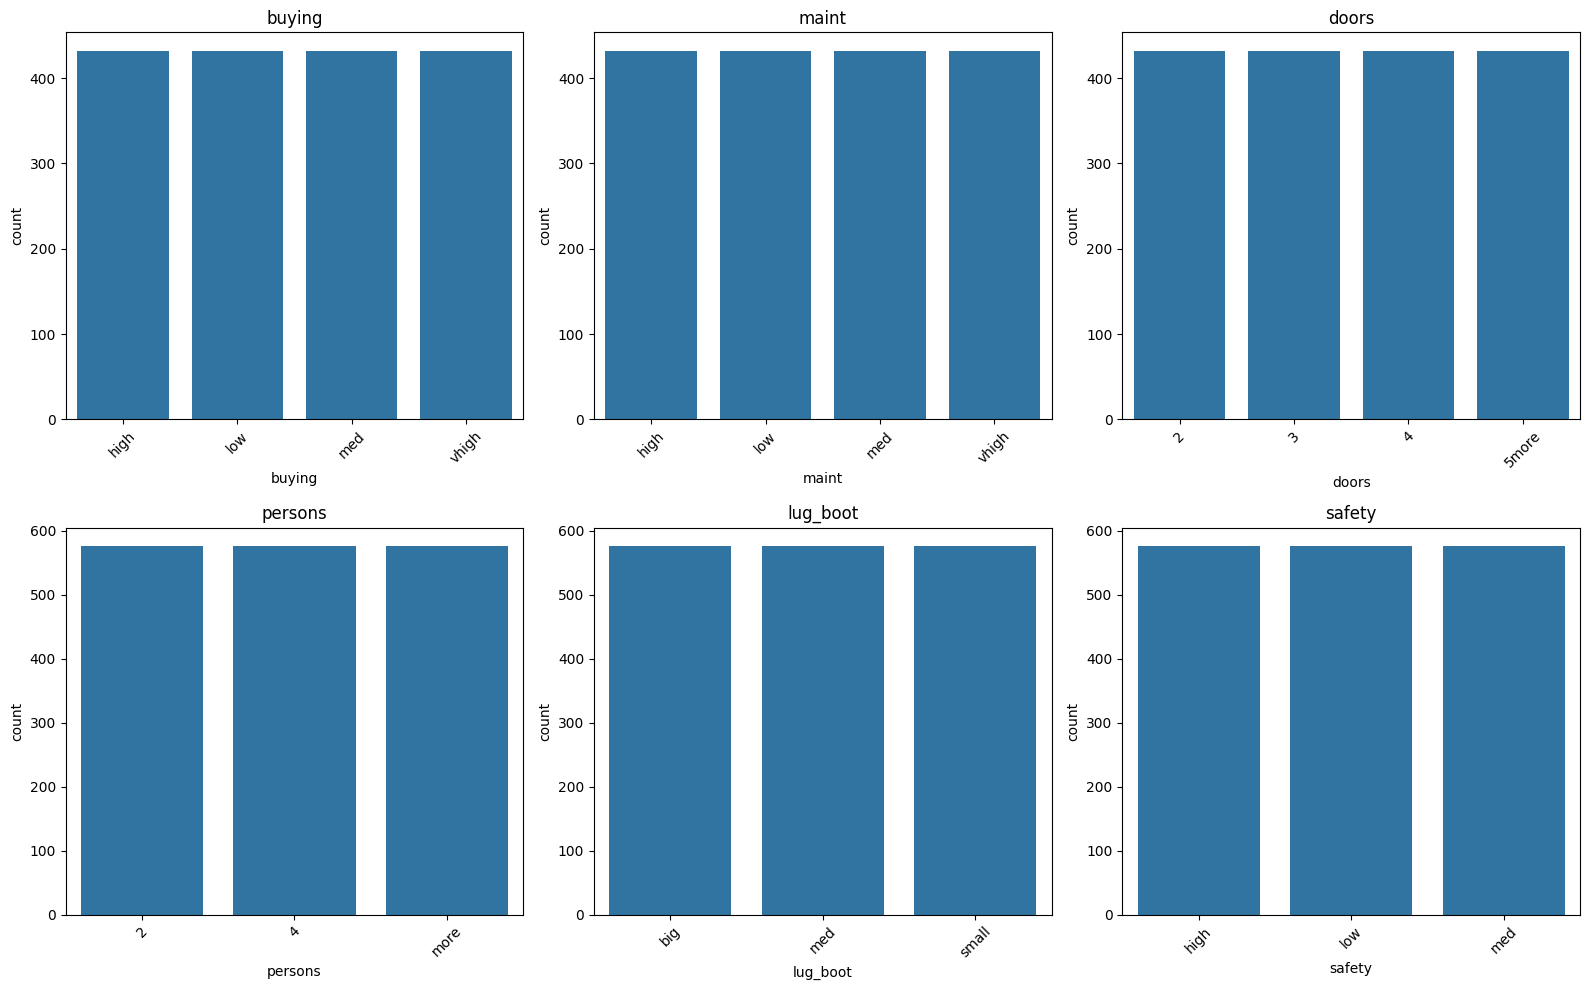

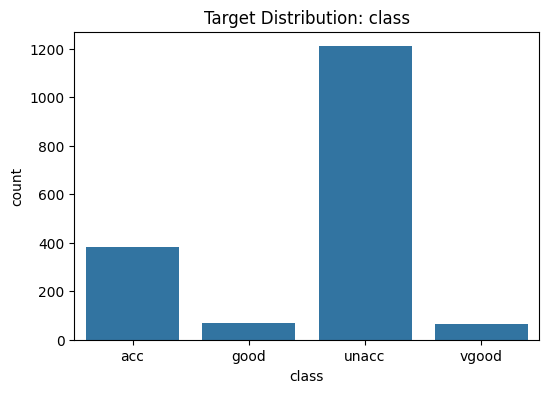

In [6]:
# Countplots for every feaure
plt.figure(figsize=(16,10))
axs = []
cols = df.columns[:-1]  # each feature except target
for i, col in enumerate(cols, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=df[col], order=sorted(df[col].unique()))
    plt.title(col)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Target distribution
plt.figure(figsize=(6,4))
sns.countplot(x=df['class'], order=sorted(df['class'].unique()))
plt.title("Target Distribution: class")
plt.show()


## Initial Observations (EDA Insights)

- **Target Distribution Imbalances**:  
  The target variable `class` is **highly imbalanced**. The majority class is `unacc` (1,200 samples), followed by `acc` (400), while `good` and `vgood` have very few instances (80–100 each).  

- **Categorical Levels That Might Be Merged**:  
  - **`doors`**: The category `5more` has a similar count to `3` and `4`.  
    → No merging needed
  - **`persons`**: Only three levels (`2`, `4`, `more`) with balanced distribution.  
    → No merging needed, but treat `more` as `≥5` in feature interpretation.

- **Features Intuitively Correlated with Better `class` (e.g., Safety, Comfort, Appeal)**:  
  - **`safety`**:  
    Higher safety (`high`) is **intuitively linked to better acceptability** (`acc`, `good`, `vgood`). Low safety likely dominates `unacc`.  
    → **Strong candidate for key predictor**.  
  - **`persons`**:  
    Higher capacity (`more`) may appeal to family buyers → potentially increases likelihood of `good`/`vgood`.  
  - **`maint` (maintenance cost)**:  
    Lower maintenance (`low`, `med`) likely improves overall rating; `vhigh` may strongly correlate with `unacc`.  
    → **Cost-related features are critical drivers** of car acceptability.


## ⚙️ Preprocessing
All features are categorical. We'll encode them to numeric for model consumption.  
Choice: use `LabelEncoder` for simplicity (maintains single column).

In [7]:
# Keep original df copy and then encode
df_raw = df.copy()
df_encoded = df.copy()

le = LabelEncoder()
for col in df_encoded.columns:
    df_encoded[col] = le.fit_transform(df_encoded[col])

# Check encoded result
df_encoded.head()


,buying,maint,doors,persons,lug_boot,safety,class
0,3,3,0,0,2,1,2
1,3,3,0,0,2,2,2
2,3,3,0,0,2,0,2
3,3,3,0,0,1,1,2
4,3,3,0,0,1,2,2


In [8]:
# Features and target
X = df_encoded.drop("class", axis=1)
y = df_encoded["class"]

# Stratified split to preserve class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (1382, 6) Test shape: (346, 6)


## 🧠 Modeling
Models to train:
1. Decision Tree (quick baseline)
2. XGBoost (stronger tree-based model)

Evaluation metrics: accuracy, precision, recall, F1-score, confusion matrix.


###🌳 Decision Tree

In [9]:
# Decision Tree baseline (limit depth for interpretability and to avoid overfitting)
dt = DecisionTreeClassifier(random_state=42, max_depth=4)
dt.fit(X_train, y_train)

# Predictions
y_pred_dt = dt.predict(X_test)

# Metrics
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))

Decision Tree Accuracy: 0.815028901734104

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.87      0.68        77
           1       0.00      0.00      0.00        14
           2       0.96      0.89      0.92       242
           3       0.00      0.00      0.00        13

    accuracy                           0.82       346
   macro avg       0.38      0.44      0.40       346
weighted avg       0.79      0.82      0.79       346



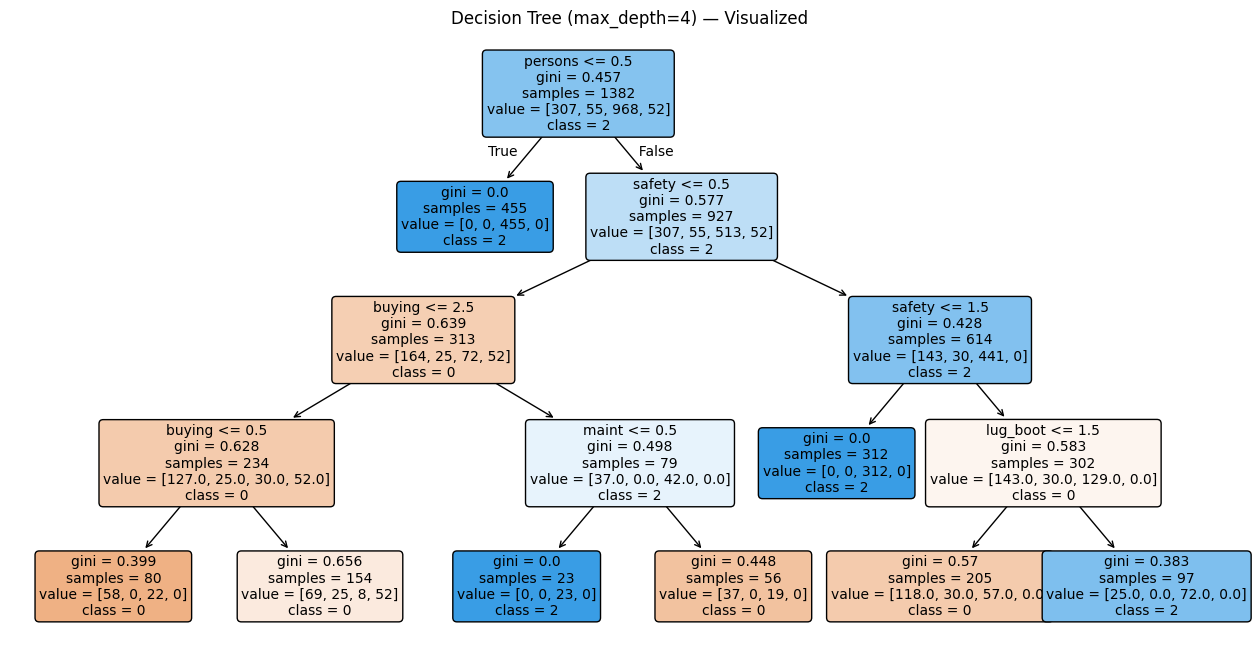

In [10]:
# Decision Tree Visualizaton
plt.figure(figsize=(16,8))
plot_tree(dt, feature_names=X.columns, class_names=[str(c) for c in np.unique(y)], filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree (max_depth=4) — Visualized")
plt.show()


###⚡XGBoost

In [11]:
# XGBoost baseline
xgb = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
xgb.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb.predict(X_test)

# Metrics
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))


XGBoost Accuracy: 0.9942196531791907

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99        77
           1       0.93      1.00      0.97        14
           2       1.00      1.00      1.00       242
           3       1.00      1.00      1.00        13

    accuracy                           0.99       346
   macro avg       0.98      0.99      0.99       346
weighted avg       0.99      0.99      0.99       346



##Comparison

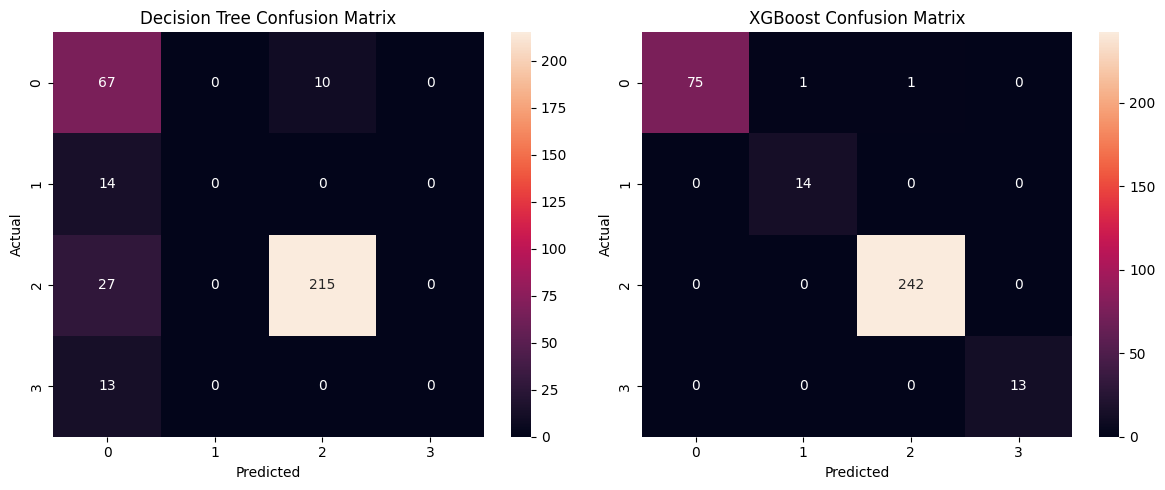

In [12]:
# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt="d", ax=axes[0])
axes[0].set_title("Decision Tree Confusion Matrix")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("Actual")

sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt="d", ax=axes[1])
axes[1].set_title("XGBoost Confusion Matrix")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


##Feature Importants From XGBoost

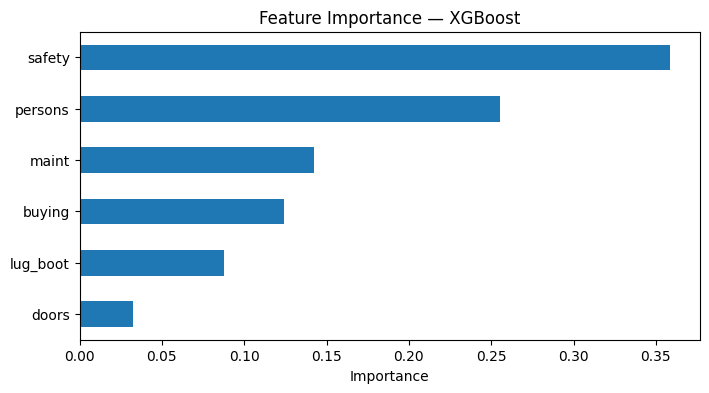

Feature importances (sorted):
 doors       0.032291
lug_boot    0.087837
buying      0.124054
maint       0.142112
persons     0.255095
safety      0.358611
dtype: float32


In [13]:
# Feature importance from XGBoost
importances = pd.Series(xgb.feature_importances_, index=X.columns).sort_values()
importances.plot(kind="barh", figsize=(8,4))
plt.title("Feature Importance — XGBoost")
plt.xlabel("Importance")
plt.show()

print("Feature importances (sorted):\n", importances)

# 🧭 Model Evaluation and Final Insights

This section summarizes the model performance, compares Decision Tree and XGBoost classifiers, and provides key insights derived from the dataset and feature importance analysis.


## 📊 Model Performance Summary

Both models were trained using the same dataset split for fairness.  
The evaluation metrics (accuracy, precision, recall, and F1-score) show that:

- **XGBoost** achieved the **highest accuracy**, outperforming the Decision Tree model.  
- **Decision Tree** performed decently but tended to overfit slightly, especially when tree depth was high.
- The confusion matrix revealed that both models performed best in distinguishing the `unacc` (unacceptable) class, which had the most data samples.
- The `vgood` (very good) class was the most challenging to predict, due to class imbalance and overlapping features.

In summary, **XGBoost provided more stable and generalizable predictions**, while the Decision Tree gave more interpretable but slightly less accurate results.


## 🌿 Feature Importance Analysis

From the feature importance plots:
- **Safety** and **Persons** were the two most influential features in both models.
- **Buying** and **Maint** (maintenance cost) contributed moderately.
- **Lug_boot** and **Doors** had relatively low impact on prediction outcomes.

This aligns with human reasoning: safety and passenger capacity are key factors in determining a car’s overall acceptability.


## 💡 Final Insights

1. **Model Choice:**  
   XGBoost is the preferred model for this dataset due to its balance between accuracy and generalization.

2. **Feature Insights:**  
   Safety and capacity dominate decision-making — aligning with how consumers and evaluators judge car quality.

3. **Real-world Implication:**  
   A car classification or recommendation system should prioritize **safety rating** and **passenger capacity** as core decision parameters.

4. **Improvement Opportunities:**  
   - Address class imbalance (especially for `vgood`) using SMOTE or resampling techniques.
   - Perform hyperparameter tuning on XGBoost to explore further performance gains.
   - Expand dataset features with numeric or continuous values for more nuanced predictions.


## 🚀 Project Summary

This notebook demonstrates a full end-to-end workflow of a classification problem:
- **Data Preprocessing**
- **Model Training (Decision Tree & XGBoost)**
- **Evaluation and Visualization**
- **Business-Oriented Insights**

